In [1]:
%%capture --no-stderr
!pip install langgraph langchain-openai langchain-community langchain-core tavily-python wikipedia


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setup - STEP 1

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "stock-market-analyzer"

In [5]:
_set_env("TAVILY_API_KEY")

## Define analyst - STEP 2

In [6]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class FinancialAnalyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst (e.g., Investment Bank, Hedge Fund).",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst (e.g., Technical Analyst, Fundamental Analyst, Sentiment Analyst).",
    )
    description: str = Field(
        description="Description of the analyst's focus, expertise, and analytical approach.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class AnalystTeam(BaseModel):
    analysts: List[FinancialAnalyst] = Field(
        description="Team of financial analysts with diverse specializations.",
    )

class GenerateAnalystsState(TypedDict):
    stock_symbol: str # Stock symbol to analyze
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[FinancialAnalyst] # Generated analysts

## Analyst Generation System - STEP 3

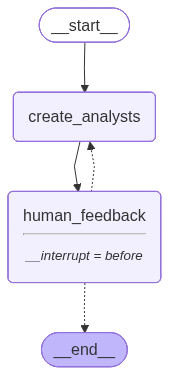

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class FinancialAnalyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst (e.g., Investment Bank, Hedge Fund).",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst (e.g., Technical Analyst, Fundamental Analyst, Sentiment Analyst).",
    )
    description: str = Field(
        description="Description of the analyst's focus, expertise, and analytical approach.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class AnalystTeam(BaseModel):
    analysts: List[FinancialAnalyst] = Field(
        description="Team of financial analysts with diverse specializations.",
    )

class GenerateAnalystsState(TypedDict):
    stock_symbol: str # Stock symbol to analyze
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[FinancialAnalyst] # Generated analysts
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a team of specialized financial analysts. Follow these instructions:

1. Review the stock symbol:
{stock_symbol}

2. Examine any editorial feedback for analyst creation:

{human_analyst_feedback}

3. Determine the most important analytical perspectives for comprehensive stock analysis.

4. Pick the top {max_analysts} perspectives.

5. Assign one analyst to each perspective with relevant expertise:
   - Technical Analysis (charts, patterns, indicators)
   - Fundamental Analysis (financials, valuations, earnings)
   - Sentiment Analysis (news, social media, market psychology)
   - Macro Analysis (economy, sector trends, regulations)"""

def create_analysts(state: GenerateAnalystsState):
    """ Create financial analysts """

    stock_symbol=state['stock_symbol']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    structured_llm = llm.with_structured_output(AnalystTeam)

    system_message = analyst_instructions.format(stock_symbol=stock_symbol,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the analyst team.")])

    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node for interruption """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

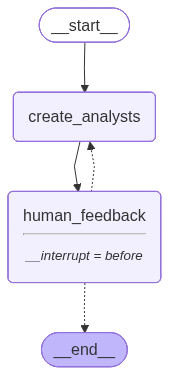

In [8]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a team of specialized financial analysts. Follow these instructions:

1. Review the stock symbol:
{stock_symbol}

2. Examine any editorial feedback for analyst creation:

{human_analyst_feedback}

3. Determine the most important analytical perspectives for comprehensive stock analysis.

4. Pick the top {max_analysts} perspectives.

5. Assign one analyst to each perspective with relevant expertise:
   - Technical Analysis (charts, patterns, indicators)
   - Fundamental Analysis (financials, valuations, earnings)
   - Sentiment Analysis (news, social media, market psychology)
   - Macro Analysis (economy, sector trends, regulations)"""

def create_analysts(state: GenerateAnalystsState):
    """ Create financial analysts """

    stock_symbol=state['stock_symbol']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    structured_llm = llm.with_structured_output(AnalystTeam)

    system_message = analyst_instructions.format(stock_symbol=stock_symbol,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the analyst team.")])

    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node for interruption """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [9]:
# Input
max_analysts = 3
stock_symbol = "TSLA"
thread = {"configurable": {"thread_id": "1"}}

# Generate analysts
for event in graph.stream({"stock_symbol":stock_symbol,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alex Johnson
Affiliation: Hedge Fund
Role: Technical Analyst
Description: Alex specializes in technical analysis with a focus on chart patterns, moving averages, and momentum indicators. He uses advanced software to identify potential entry and exit points for TSLA, leveraging historical price data and volume trends.
--------------------------------------------------
Name: Emily Chen
Affiliation: Investment Bank
Role: Fundamental Analyst
Description: Emily is an expert in fundamental analysis, focusing on Tesla's financial statements, valuation metrics, and earnings reports. She evaluates the company's growth prospects, competitive position, and financial health to provide long-term investment insights.
--------------------------------------------------
Name: Michael Lee
Affiliation: Market Research Firm
Role: Sentiment Analyst
Description: Michael analyzes market sentiment by monitoring news, social media, and investor forums. He assesses the psychological factors influencing TS

In [10]:
state = graph.get_state(thread)
state.next


('human_feedback',)

In [11]:
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cf5a2-8a90-6f0b-8002-6659dc4e7576'}}

In [12]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')
analysts

[FinancialAnalyst(affiliation='Hedge Fund', name='Alex Johnson', role='Technical Analyst', description='Alex specializes in technical analysis with a focus on chart patterns, moving averages, and momentum indicators. He uses advanced software to identify potential entry and exit points for TSLA, leveraging historical price data and volume trends.'),
 FinancialAnalyst(affiliation='Investment Bank', name='Emily Chen', role='Fundamental Analyst', description="Emily is an expert in fundamental analysis, focusing on Tesla's financial statements, valuation metrics, and earnings reports. She evaluates the company's growth prospects, competitive position, and financial health to provide long-term investment insights."),
 FinancialAnalyst(affiliation='Market Research Firm', name='Michael Lee', role='Sentiment Analyst', description="Michael analyzes market sentiment by monitoring news, social media, and investor forums. He assesses the psychological factors influencing TSLA's stock price, identi

## Research Analysis Workflow - STEP 4

In [14]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class AnalysisState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: FinancialAnalyst # Analyst conducting analysis
    analysis: str # Analysis transcript
    sections: list # Final sections for report

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for financial news retrieval.")

In [15]:
question_instructions = """You are a financial analyst conducting research on {stock}.

Your goal is to gather specific, actionable insights about the stock.

1. Actionable: Insights that can inform investment decisions.

2. Specific: Include concrete data, numbers, and recent developments.

Your analytical focus: {goals}

Begin by introducing yourself, then pose your analytical questions.

Continue to drill down until you have comprehensive insights.

When satisfied with your analysis, conclude with: \"Analysis complete!\"

Stay in character throughout your response."""

def generate_question(state: AnalysisState):
    """ Generate analysis question """

    analyst = state["analyst"]
    messages = state["messages"]

    system_message = question_instructions.format(stock=state.get("stock_symbol", "the stock"), goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    return {"messages": [question]}

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17332\596536740.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


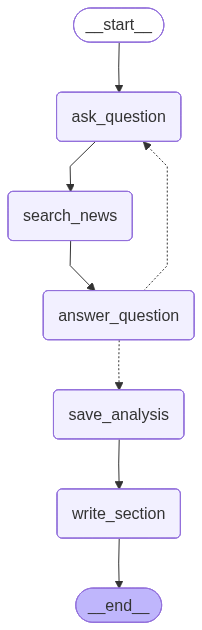

In [17]:
from langchain_core.messages import get_buffer_string

search_instructions = SystemMessage(content=f"""Generate a search query for recent news and information.

Focus on the latest developments, news, and data points relevant to the conversation.

The query should be specific and targeted for financial news sources.""")

def search_news(state: AnalysisState):
    """ Search for financial news """
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    try:
        search_docs = tavily_search.invoke(search_query.search_query)
    except Exception:
        search_docs = []

    if not search_docs:
        formatted_search_docs = ""
    else:
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
                for doc in search_docs
            ]
        )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are a financial information expert.

Analyst focus: {goals}

Answer the analyst's question using this context:

{context}

Guidelines:

1. Use only information from the provided context.

2. Include specific numbers, dates, and data points.

3. Cite sources using [1], [2], etc.

4. List sources at the end:

[1] Source 1
[2] Source 2"""

def generate_answer(state: AnalysisState):
    """ Generate answer """
    analyst = state["analyst"]
    messages = state["messages"]
    context = state.get("context", [])

    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    answer.name = "expert"

    return {"messages": [answer]}

def save_analysis(state: AnalysisState):
    """ Save analysis """
    messages = state["messages"]
    analysis = get_buffer_string(messages)
    return {"analysis": analysis}

def route_messages(state: AnalysisState, name: str = "expert"):
    """ Route between question and answer """

    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    if num_responses >= max_num_turns:
        return 'save_analysis'

    last_question = messages[-2]

    if "Analysis complete" in last_question.content:
        return 'save_analysis'
    return "ask_question"

section_writer_instructions = """You are a financial report writer.

Create a concise, professional section based on analyst research.

1. Analyze the source documents containing analyst research.

2. Use this structure:
## {focus} (section title)

### Key Findings

### Analysis

### Sources

3. Analyst focus: {focus}

4. Key Findings:
- Highlight specific data points and numbers
- Include dates and timeframes
- Note significant trends or changes

5. Analysis:
- Explain implications
- Connect findings to investment perspective
- Maximum 300 words
- Use numbered sources [1], [2]

6. Sources:
- Include all sources used
- Format: [1] URL or source name
- One per line
"""

def write_section(state: AnalysisState):
    """ Write report section """
    analysis = state["analysis"]
    context = state.get("context", [])
    analyst = state["analyst"]

    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this research: {context}")])

    return {"sections": [section.content]}

# Build analysis sub-graph
analysis_builder = StateGraph(AnalysisState)
analysis_builder.add_node("ask_question", generate_question)
analysis_builder.add_node("search_news", search_news)
analysis_builder.add_node("answer_question", generate_answer)
analysis_builder.add_node("save_analysis", save_analysis)
analysis_builder.add_node("write_section", write_section)

analysis_builder.add_edge(START, "ask_question")
analysis_builder.add_edge("ask_question", "search_news")
analysis_builder.add_edge("search_news", "answer_question")
analysis_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_analysis'])
analysis_builder.add_edge("save_analysis", "write_section")
analysis_builder.add_edge("write_section", END)

memory = MemorySaver()
analysis_graph = analysis_builder.compile(checkpointer=memory).with_config(run_name="Conduct Analysis")

display(Image(analysis_graph.get_graph().draw_mermaid_png()))

## Parallel analysis for report generation - STEP 5

In [18]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    stock_symbol: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[FinancialAnalyst]
    sections: Annotated[list, operator.add]
    introduction: str
    content: str
    conclusion: str
    final_report: str

C:\Users\Admin\AppData\Local\Temp\ipykernel_17332\1934057129.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


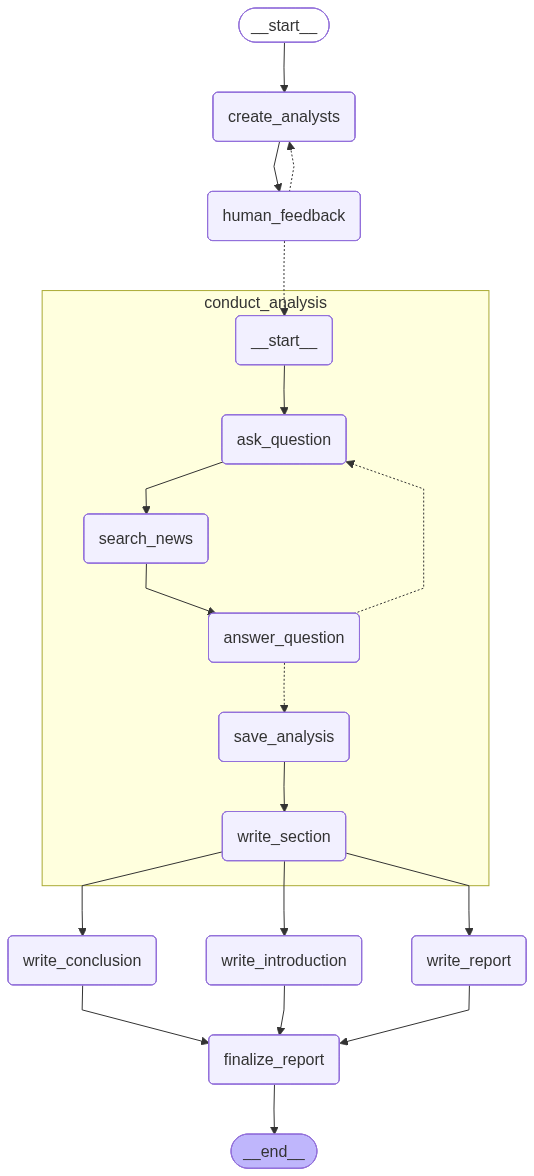

In [19]:
from langgraph.constants import Send

def initiate_all_analyses(state: ResearchGraphState):
    """ Map step: run each analysis using Send API """

    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return "create_analysts"

    else:
        stock_symbol = state["stock_symbol"]
        return [Send("conduct_analysis", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"Analyze {stock_symbol} from your perspective."
                                           )],
                                           "stock_symbol": stock_symbol}) for analyst in state["analysts"]]

report_writer_instructions = """You are creating an investment analysis report on:

{stock_symbol}

Your analyst team has completed their research.

Task:

1. Review all analyst sections
2. Identify key insights and themes
3. Synthesize into a cohesive narrative
4. Highlight actionable conclusions

Format:

1. Use markdown
2. No preamble
3. No sub-headings
4. Start with: ## Investment Analysis
5. Preserve all citations [1], [2], etc.
6. Create consolidated Sources section:

## Sources
[1] Source 1
[2] Source 2

Analyst sections:

{context}"""

def write_report(state: ResearchGraphState):
    sections = state["sections"]
    stock_symbol = state["stock_symbol"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    system_message = report_writer_instructions.format(stock_symbol=stock_symbol, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write the investment analysis report.")])
    return {"content": report.content}

introduction_instructions = """You are writing an investment analysis report on {stock_symbol}

You have all report sections available.

Write a compelling introduction section.

No preamble.

Target 100 words.

Use markdown.

Create a compelling title with # header, then ## Introduction section.

Preview the key areas of analysis covered in the report.

Report sections: {formatted_str_sections}"""

conclusion_instructions = """You are writing an investment analysis report on {stock_symbol}

You have all report sections available.

Write a conclusion section.

No preamble.

Target 100 words.

Use markdown.

Use ## Conclusion header.

Summarize the key investment insights and provide an overall perspective.

Report sections: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    """Write report introduction"""
    sections = state["sections"]
    stock_symbol = state["stock_symbol"]

    formatted_str_sections = "\\n\\n".join([f"{section}" for section in sections])

    instructions = introduction_instructions.format(
        stock_symbol=stock_symbol,
        formatted_str_sections=formatted_str_sections
    )

    intro = llm.invoke([SystemMessage(content=instructions)] +
                       [HumanMessage(content="Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    """Write report conclusion"""
    sections = state["sections"]
    stock_symbol = state["stock_symbol"]

    formatted_str_sections = "\\n\\n".join([f"{section}" for section in sections])

    instructions = conclusion_instructions.format(
        stock_symbol=stock_symbol,
        formatted_str_sections=formatted_str_sections
    )

    conclusion = llm.invoke([SystemMessage(content=instructions)] +
                           [HumanMessage(content="Write the report conclusion")])
    return {"conclusion": conclusion.content}


def finalize_report(state: ResearchGraphState):
    """ Reduce step: combine all sections """
    content = state["content"]
    if content.startswith("## Investment Analysis"):
        content = content.strip("## Investment Analysis")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Build main graph
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_analysis", analysis_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_analyses, ["create_analysts", "conduct_analysis"])
builder.add_edge("conduct_analysis", "write_report")
builder.add_edge("conduct_analysis", "write_introduction")
builder.add_edge("conduct_analysis", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Report and Word document generation - STEP 6

In [20]:
!pip install python-docx



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from IPython.display import Markdown
from docx import Document
# Input
max_analysts = 3
stock_symbol = "NVDA"  # NVIDIA
thread = {"configurable": {"thread_id": "1"}}

# Run the analysis
final_report = None
for event in graph.stream({"stock_symbol":stock_symbol,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="updates"):
    print(f"Processing: {list(event.keys())}")
    if "finalize_report" in event:
        final_report = event["finalize_report"]["final_report"]

# Display final report
if final_report:
    display(Markdown(final_report))
    document = Document()
    document.add_paragraph(final_report)
    document.save("analysis.docx")


Processing: ['create_analysts']
Processing: ['human_feedback']
Processing: ['conduct_analysis']
Processing: ['conduct_analysis']
Processing: ['conduct_analysis']
Processing: ['write_conclusion']
Processing: ['write_introduction']
Processing: ['write_report']
Processing: ['finalize_report']


# NVDA Investment Analysis Report

## Introduction

NVIDIA Corporation (NVDA) stands at the forefront of the semiconductor industry, driven by its pioneering advancements in AI and accelerated computing. This report delves into a comprehensive analysis of NVDA, exploring its technical and fundamental aspects, as well as the macroeconomic factors influencing its market position. Alice's technical analysis highlights key chart patterns and momentum indicators, offering insights into potential stock movements. Michael's fundamental analysis evaluates NVDA's financial health and growth prospects, while Sophia examines the broader economic environment and regulatory impacts. Together, these analyses provide a holistic view of NVDA's investment potential, guiding informed decision-making for investors.

---



NVIDIA (NVDA) presents a compelling investment opportunity, characterized by robust financial performance, strategic positioning in the AI sector, and a mixed technical outlook. The company's recent financial results for Q3 FY24 highlight significant growth, with revenue reaching $18.12 billion, a 206% increase year-over-year, and a 34% rise from the previous quarter [1]. This growth is driven by NVIDIA's leadership in AI and accelerated computing, underscoring its strong market position and operational efficiency.

From a technical analysis perspective, NVDA's stock price of $177.17 surpasses the 50-day simple moving average, indicating a bullish sentiment [1]. However, the MACD's negative reading and the RSI's overbought status suggest potential bearish momentum, necessitating caution for investors [2]. The Bollinger Bands provide conflicting signals, with short-term indicators suggesting a sell and long-term indicators suggesting a buy, highlighting the importance of considering multiple timeframes [2]. Despite these mixed signals, historical chart patterns forecast a bullish target of $255, with a potential upside to $325, suggesting significant growth potential [3][4].

Fundamentally, NVIDIA's financial health is robust, with a GAAP gross margin of 74.0% and a dramatic rise in operating and net income, up 1,633% and 1,259% respectively [1]. The company's liquidity ratios, with a quick ratio of 3.37 and a current ratio of 4.21, reflect strong financial stability, providing flexibility for future investments [2]. NVIDIA's forward P/E ratio of 23.53 and a PEG ratio of 0.69 indicate potential undervaluation, especially when compared to peers like AMD [2].

Macroeconomic factors further support NVIDIA's growth prospects. The company's strategic investments in AI infrastructure, including a $100 billion commitment to OpenAI, position it as a leader in the AI sector [1]. However, new U.S. export restrictions could impact sales of high-end AI chips in certain countries, posing a potential risk to international market reach [3]. Despite this, NVIDIA's market valuation continues to grow, driven by its leadership in AI chip technology [4].

In conclusion, NVIDIA's strong financial performance, strategic investments, and leadership in AI make it an attractive investment opportunity. While technical indicators suggest caution in the short term, the company's growth trajectory and market position offer significant long-term potential. Investors should consider NVIDIA's ability to navigate regulatory challenges and capitalize on emerging opportunities in the AI and technology sectors.


---

## Conclusion

NVIDIA presents a compelling investment opportunity, driven by its robust financial performance, strategic positioning in AI, and potential for significant growth. The technical analysis indicates mixed signals, with a bullish long-term outlook despite short-term volatility. The stock's current undervaluation, as evidenced by its low forward P/E ratio, suggests potential upside, especially given historical recovery patterns. NVIDIA's impressive revenue growth and profitability underscore its market leadership and operational efficiency. However, investors should remain vigilant of regulatory challenges that may impact international sales. Overall, NVIDIA's strong financial health and strategic investments position it as an attractive option for growth-oriented investors.

## Sources
[1] https://investor.nvidia.com/news/press-release-details/2023/NVIDIA-Announces-Financial-Results-for-Third-Quarter-Fiscal-2024/default.aspx  
[2] https://www.morningstar.com/stocks/xnas/nvda/quote  
[3] https://www.reuters.com/technology/nvidia-may-be-forced-shift-out-some-countries-after-new-us-export-curbs-2023-10-17/  
[4] https://www.reuters.com/technology/nvidia-results-show-its-growing-lead-ai-chip-race-2023-02-23/